In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import time
from tot_cgs import TOT_CGS
import datetime
from scipy.special import beta
from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

# setup variables
M = 5000
V = 2000
K = 40

# load data, remove short and lost posts, wrangle data, and subset data
data = pd.read_csv("../unbounce/data/processed/cleaned_no_apos_2chr_rem.csv")
data = data[data['cleaned_length'] > 40]
data = data[data['cleaned_length'] < 3000]
data = data.sample(M)

# create timestamp column with time values between 0 and 1
data["ymd_created_at"] = data["created_at"].astype(str).str[0:10]
data['timestamp'] = [time.mktime(datetime.datetime.strptime(i, "%Y-%m-%d").timetuple()) for i in data['ymd_created_at']]
data['timestamp'] = data['timestamp'] - min(data['timestamp'])
data['timestamp'] = data['timestamp'] / max(data['timestamp'])
data.loc[data['timestamp'] == 0, 'timestamp'] = 0.000001
data.loc[data['timestamp'] == 1, 'timestamp'] = 0.999999

data = data.sort_values(by='timestamp')[['cleaned', 'timestamp']]

# create BOW data
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = 'english',
                             max_features = V)
X = vectorizer.fit_transform(data['cleaned'])

# dictionary of word - index pairs
volcabulary_indices_words_dict = dict((v,k) for k,v in vectorizer.vocabulary_.items())

In [2]:
tot_model = TOT_CGS()
tot_model.fit(X = X, timestamps = np.array(data['timestamp']))

Initializing variables...
Performing Gibbs Sampling...
	Iteration 1, 1.00% complete, 0 mins elapsed
	Iteration 2, 2.00% complete, 1 mins elapsed
	Iteration 3, 3.00% complete, 1 mins elapsed
	Iteration 4, 4.00% complete, 2 mins elapsed
	Iteration 5, 5.00% complete, 2 mins elapsed
	Iteration 6, 6.00% complete, 3 mins elapsed
	Iteration 7, 7.00% complete, 3 mins elapsed
	Iteration 8, 8.00% complete, 3 mins elapsed
	Iteration 9, 9.00% complete, 4 mins elapsed
	Iteration 10, 10.00% complete, 4 mins elapsed
	Iteration 11, 11.00% complete, 5 mins elapsed
	Iteration 12, 12.00% complete, 5 mins elapsed
	Iteration 13, 13.00% complete, 6 mins elapsed
	Iteration 14, 14.00% complete, 6 mins elapsed
	Iteration 15, 15.00% complete, 6 mins elapsed
	Iteration 16, 16.00% complete, 7 mins elapsed
	Iteration 17, 17.00% complete, 7 mins elapsed
	Iteration 18, 18.00% complete, 8 mins elapsed
	Iteration 19, 19.00% complete, 8 mins elapsed
	Iteration 20, 20.00% complete, 9 mins elapsed
	Iteration 21, 21.00% c

In [352]:
variables = tot_model.get_model_variables()
parameters = tot_model.get_model_parameters()
hyperparameters = tot_model.get_model_hyperparameters()

In [265]:
document_topic_matrix = parameters['document_topic_matrix']

In [134]:
timestamps_for_all_words = variables['timestamps_for_all_words']
Z = variables['Z']
timestamps = variables['timestamps']
psi = parameters['psi']

In [4]:
num_top_words_to_see = 20 # number of keywords to see for each topic
def get_top_words_for_topics(volcabulary_indices_words_dict, topic_word_matrix):
    top_indices_of_topics = np.argsort(topic_word_matrix, axis = 1)[:, np.arange(1, num_top_words_to_see+1)*-1].transpose()
    top_words_of_topics = pd.DataFrame(np.ndarray((num_top_words_to_see, K)))
    for i in range(top_words_of_topics.shape[0]):
        for j in range(top_words_of_topics.shape[1]):
            top_words_of_topics.loc[i, j] = volcabulary_indices_words_dict[top_indices_of_topics[i, j]]
    top_words_of_topics.columns = ["Topic %d"%i for i in range(K)]
    return(top_words_of_topics)

In [6]:
def plot_beta(psi, topic_number):
    a, b = psi[topic_number, :]
    x = np.linspace(0.001, 0.999, num = 100)
    return(plt.plot(x, beta.pdf(x, a, b), lw=1, alpha=0.6))

In [245]:
num_words_belonging_to_topics = [sum(Z == k) for k in range(K)]
proportion_of_words_belonging_to_topics = num_words_belonging_to_topics/sum(num_words_belonging_to_topics)

In [247]:
def stackplot_beta(psi):
    x = np.linspace(0.01, 0.99, num = 100)
    res = np.zeros((100, psi.shape[0]))
    for k in range(psi.shape[0]):
        a, b = psi[k, :]
        res[:,k] = [beta.pdf(x_i, a, b) for x_i in x]
    # adjust for topic importance
    res *= proportion_of_words_belonging_to_topics
    # normalize for each x_i
    res_normalized = res / np.sum(res, axis = 1)[:, np.newaxis]
    plt.stackplot(x, [res_normalized[:,k] for k in range(psi.shape[0])])
    plt.show()

In [347]:
get_top_words_for_topics(volcabulary_indices_words_dict, parameters['topic_word_matrix'])

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 30,Topic 31,Topic 32,Topic 33,Topic 34,Topic 35,Topic 36,Topic 37,Topic 38,Topic 39
0,like,url,page,script,email,know,hey,unbounce,support,link,...,feedback,going,integration,conversion,help,code,page,link,content,work
1,new,using,best,problem,possible,let,bit,use,issue,want,...,great,view,trying,traffic,need,script,want,page,did,working
2,looks,set,test,hey,address,list,try,page,cheers,visitors,...,idea,account,able,conversions,thanks,javascript,elements,section,marketing,number
3,time,option,variant,looking,issues,lot,right,just,team,question,...,love,getting,thanks,adwords,sure,html,redirect,background,template,phone
4,process,need,hristian,trying,having,change,issue,way,like,based,...,design,look,adding,campaign,load,custom,header,change,got,having
5,today,lightbox,variants,did,display,questions,hope,topic,stuart,example,...,product,good,hear,lead,nice,confirmation,fixed,properties,way,regards
6,luck,example,upload,convertables,contact,cta,helps,create,directly,element,...,better,set,understand,ads,currently,add,way,links,download,external
7,updated,options,buttons,actually,look,best,post,new,right,probably,...,customers,screen,look,search,reply,tag,place,sections,doing,inside
8,sounds,wordpress,capture,works,need,place,helpful,landing,ticket,page,...,users,thread,coming,campaigns,details,following,appear,color,current,correct
9,folks,api,say,value,font,right,community,pages,just,away,...,experience,like,live,rate,extra,manager,width,replace,love,unfortunately


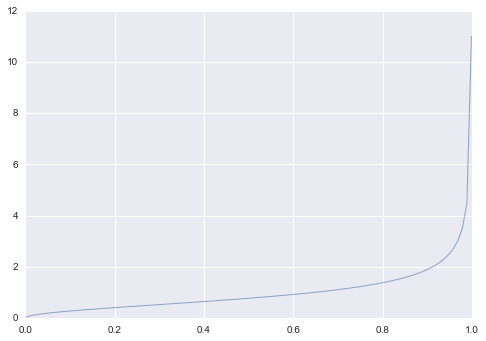

In [351]:
plot_beta(psi, 10)

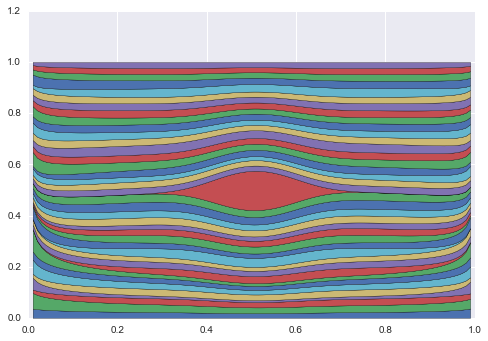

In [350]:
stackplot_beta(psi)
# TODO: label topics / show label on hover

In [345]:
def plot_topics_cooccuring_with_topic(topic_to_compare_with, document_topic_matrix):
    K = document_topic_matrix.shape[1]
    cooccurring_topics = np.zeros((10, K))
    # do this for 10 timestamp intervals (intervals of 0.1)
    for i in range(10):
        # select all documents in the timestamp interval
        documents_in_timestamp_range = document_topic_matrix[(timestamps >= 0.1*i) & (timestamps < 0.1*(i+1))]
        # get number of documents in timestamp interval
        num_documents = documents_in_timestamp_range.shape[0]
        # for every document within documents_in_timestamp_range,
        for doc in documents_in_timestamp_range:
            # if the topic_to_compare_with has a probability greater that 2/K,
            if doc[topic_to_compare_with] >= 2/K:
                # for every topic,
                for k in range(K):
                    if k == topic_to_compare_with:
                        continue
                    else:
                        if doc[k] >= 2/K:
                            cooccurring_topics[i, k] += 1
        cooccurring_topics[i, :] /= sum(cooccurring_topics[i, :])
    plt.stackplot(range(10), [cooccurring_topics[:,k] for k in range(40)])
    plt.show()

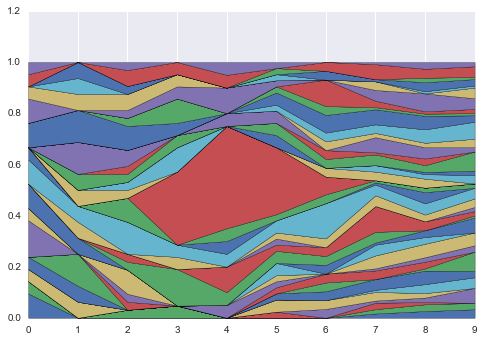

In [346]:
plot_topics_cooccuring_with_topic(21, document_topic_matrix)
# TODO: add tags showing number of topics in each interval
# TODO: label topics/show label on hover

In [ ]:
# http://stackoverflow.com/questions/31573869/label-areas-in-python-matplotlib-stackplot
# http://stackoverflow.com/questions/7908636/possible-to-make-labels-appear-when-hovering-over-a-point-in-matplotlib

In [372]:
import pickle
def save_model(model, filename):
    file = open(filename, 'wb')
    pickle.dump([model.get_model_variables(), 
                 model.get_model_parameters(), 
                 model.get_model_hyperparameters()], 
                file)
    file.close()
def load_model(filename):
    file = open(filename, 'rb')
    variables_parameters_hyperparameters = pickle.load(file)
    return(variables_parameters_hyperparameters)

In [373]:
save_model(tot_model, "tot_model.txt")

In [375]:
variables_parameters_hyperparameters = load_model("tot_model.txt")